In [1]:
%matplotlib inline

import os
import glob
import re

import arviz as az
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr

plt.style.use("./paper.mplstyle")

In [2]:
samp_df_files = glob.glob("../results/sample_size/sim/*.tsv")
samp_df_files
samp_regex = re.compile("../results/sample_size/sim/sim_counts.num_samps_(\d+).tsv")

samp_df_files = sorted(samp_df_files, key=lambda x: int(samp_regex.search(x).groups()[0]))
samp_dict = dict()
for f in samp_df_files:
    num_samps = samp_regex.search(f).groups()[0]
    _df = pd.read_table(f, index_col=0, sep="\t")
    _df["depth"] = np.exp(_df["log_depth"])
    samp_dict[num_samps] = _df

In [3]:
beta_var_df = pd.read_table("../results/sample_size/post_beta_var_df.tsv", sep="\t", index_col=0)
order = list(map(str, sorted(beta_var_df["sample_size"].unique())))
beta_var_df["sample_size"] = pd.Categorical(beta_var_df["sample_size"].astype(str),
                                            categories=order,
                                            ordered=True)
print(beta_var_df.shape)
beta_var_df.head()

(28000, 3)


,sample_size,column,value
0,100,Intercept,-5.75782
1,100,Intercept,-5.55302
2,100,Intercept,-8.10312
3,100,Intercept,-7.46344
4,100,Intercept,-7.74975


In [4]:
inv_disp_df = pd.read_table("../results/sample_size/post_inv_disp_df.tsv", sep="\t", index_col=0)
inv_disp_df["sample_size"] = pd.Categorical(inv_disp_df["sample_size"].astype(str),
                                            categories=order,
                                            ordered=True)
print(inv_disp_df.shape)
inv_disp_df.head()

(14000, 2)


,sample_size,value
0,100,11.69010
1,100,8.54869
2,100,9.71345
3,100,8.86604
4,100,8.37455


In [5]:
order

['50', '100', '200', '500', '1000', '5000', '10000']

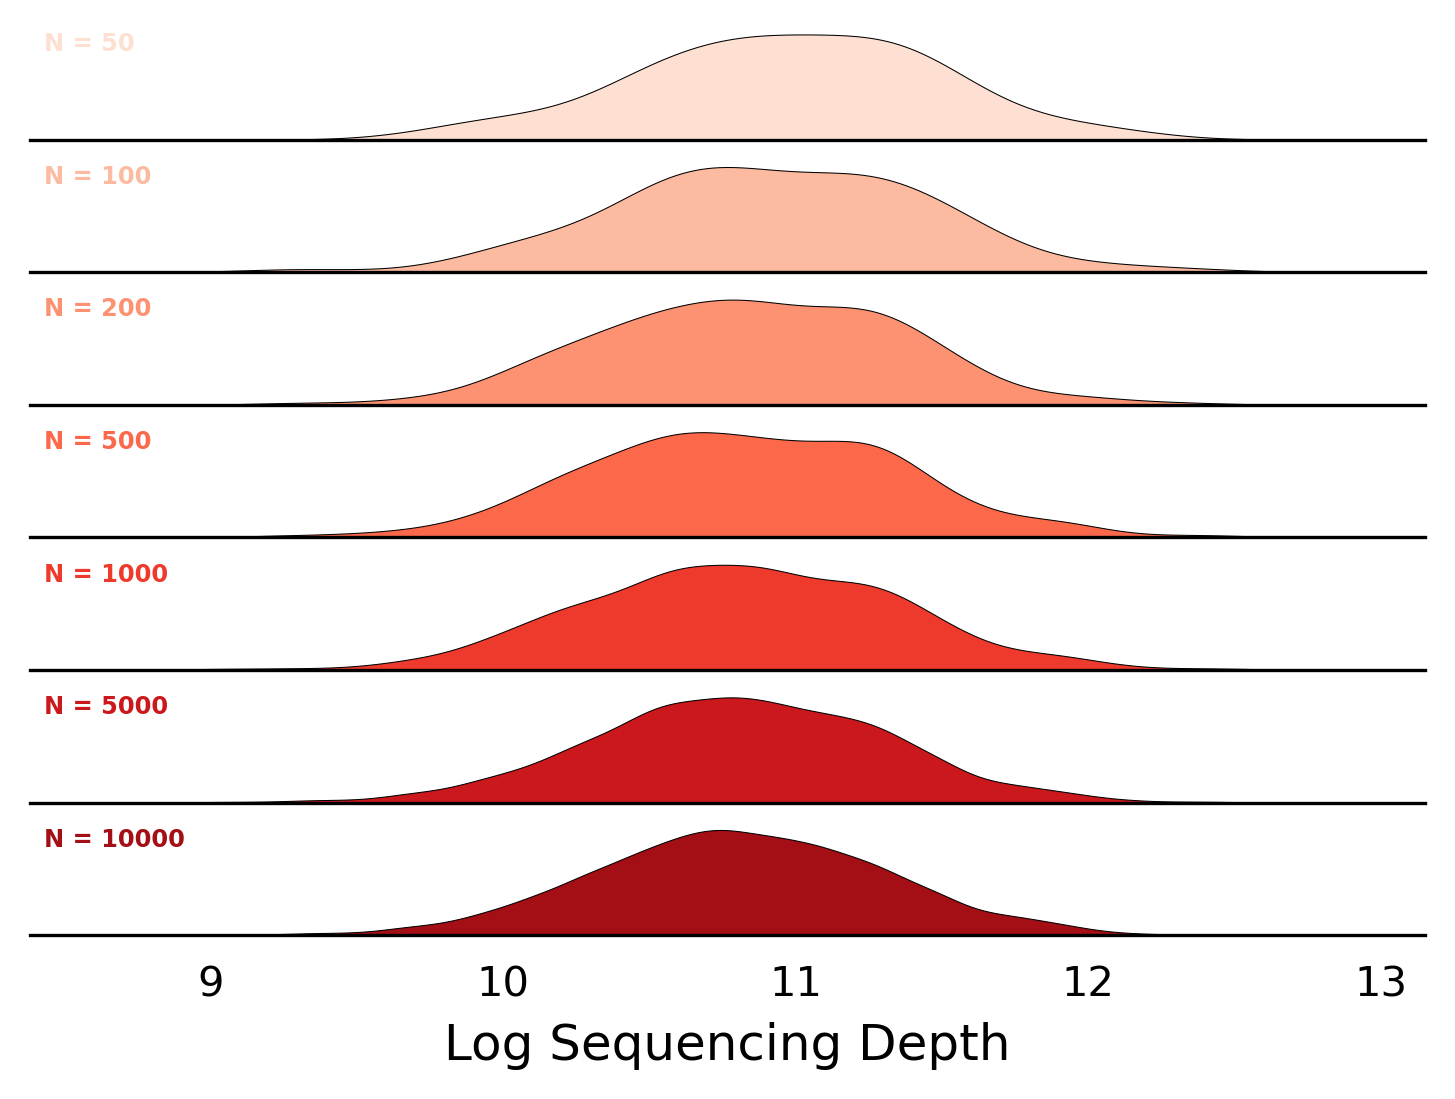

In [6]:
palette = dict(zip(
    order,
    sns.color_palette("Reds", len(order))
))

num_samp_sizes = len(samp_dict)

fig, axs = plt.subplots(num_samp_sizes, 1, sharex=True)

for ax, (num_samps, _df) in zip(axs, samp_dict.items()):
    ax.set_clip_on(True)
    sns.kdeplot(
        _df["log_depth"],
        ax=ax,
        color=palette[num_samps],
        fill=True,
        edgecolor="black",
        lw=0.25,
        alpha=1,
        clip_on=False
    )
    ax.spines["left"].set_visible(False)
    ax.yaxis.set_visible(False)
    ax.tick_params("x", width=0)
    
    ax.text(
        x=0.01,
        y=0.98,
        s=f"N = {num_samps}",
        transform=ax.transAxes,
        fontsize="xx-small",
        color=palette[num_samps],
        fontweight="bold",
        ha="left",
        va="top"
    )

ax.set_xlabel("Log Sequencing Depth")

plt.show()

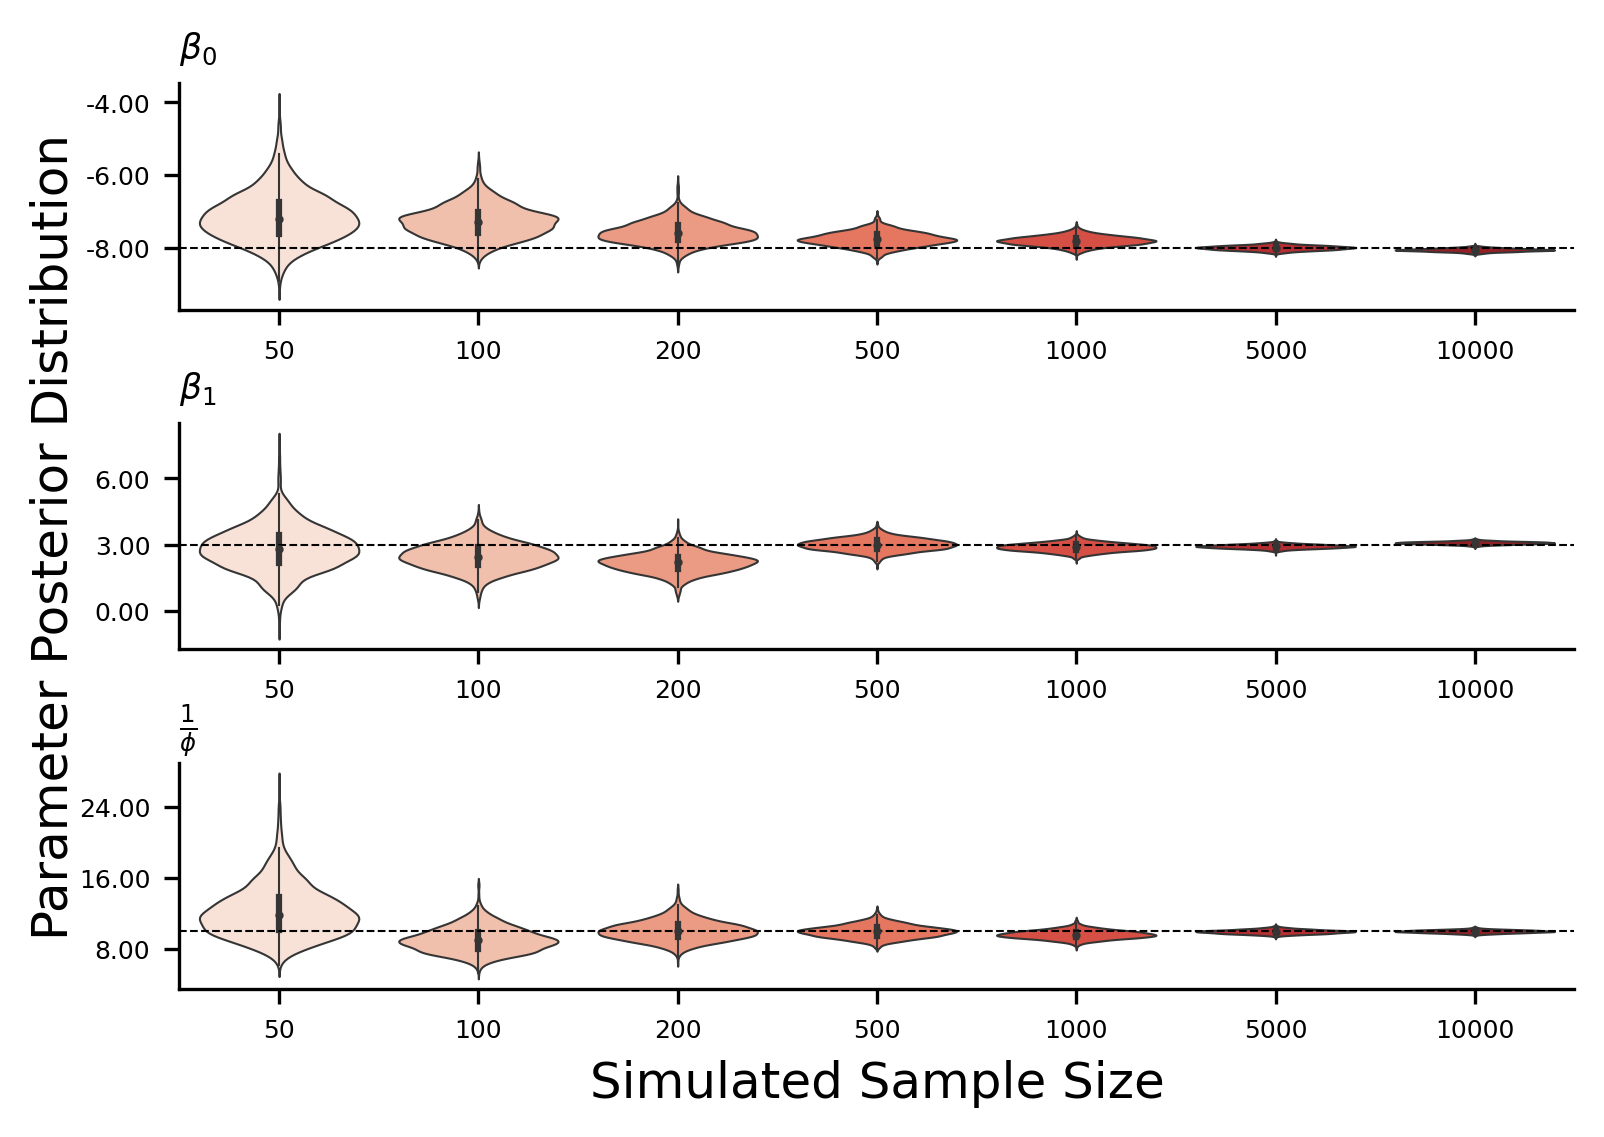

In [8]:
import matplotlib.ticker as ticker
from matplotlib.patches import Patch

fig, axs = plt.subplots(3, 1)
plt.subplots_adjust(hspace=0.5)
coef_dict = {"Intercept": r"$\beta_0$", "beta_case": r"$\beta_1$"}
palette = dict(zip(
    order,
    sns.color_palette("Reds", len(order))
))

true_vals = [-8, 3]

violin_args = {
    "x": "sample_size",
    "y": "value",
    "palette": palette,
    "linewidth": 0.5, 
    "scale": "width"
}
for (col, _df), ax, true_val in zip(beta_var_df.groupby("column"), axs, true_vals):
    sns.violinplot(
        data=_df,
        ax=ax,
        **violin_args,
    )
    ax.axhline(true_val, color="black", ls="--", lw=0.5)
    ax.set_xlabel("")
    ax.set_title(coef_dict[col], fontsize="small")

sns.violinplot(
    data=inv_disp_df,
    ax=axs[2],
    **violin_args,
)
axs[2].axhline(10, ls="--", color="black", lw=0.5)

axs[2].set_title(r"$\frac{1}{\phi}$", fontsize="small")

for ax in axs:
    ax.tick_params("both", labelsize=6)
    ax.set_ylabel("")

axs[1].set_ylabel("Parameter Posterior Distribution")
axs[2].set_xlabel("Simulated Sample Size")

for ax in axs:
    ax.yaxis.set_major_locator(ticker.MaxNLocator(4))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))

plt.savefig("../figures/simulation/sample_size_uncertainty.pdf")
plt.show()